In [6]:
import numpy as np
import phate, magic
import scprep, scanpy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import leidenalg

In [25]:
dataset = '3_branches'

In [8]:
names = ['GSPA_QR', 'DiffusionEMD', 'GAE_att_Gcell', 'GAE_noatt_Gcell', 'MAGIC',
       'Node2Vec_Gcell', 'Signals', 'GSPA', 'GAE_att_Ggene',
       'GAE_noatt_Ggene', 'Node2Vec_Ggene', 'Eigenscore', 'GFMMD']

clist = ['black', 'light yellow', 'purple', 'forest', 'mustard', 'teal',
         'berry', 'gray', 'light purple', 'light forest', 'light teal', 'white', 'sienna']

colors = {'mustard': '#E1AD01', 'berry': '#AC2F3D', 'teal': '#216E76', 'purple':'#502A4F', 'forest': '#065535', 'light forest': '#519167',
          'light yellow': '#E3BC81', 'light berry': '#c7505d', 'light teal': '#81ABA1', 'light purple': '#95636E', 'black': '#000000', 'gray':'#808080', 'white':'white', 'sienna':'sienna'}

cmap = {0: 'berry', 1:'light teal', 2:'mustard', 3:'forest', 4:'light purple'}

In [13]:
trajectory_data = np.load(f'../data/splatter_simulated_data_{dataset}.npz')
data = trajectory_data['data']
true_counts = trajectory_data['true_counts']
true_lib_size = true_counts.T.sum(axis=1)
time = trajectory_data['pseudotime'] / 10000

In [14]:
cell_phate_op = phate.PHATE(random_state=1234)
cell_data_phate = cell_phate_op.fit_transform(data)

cell_phate_op = phate.PHATE(random_state=1234)
true_cell_data_phate = cell_phate_op.fit_transform(true_counts)

Calculating PHATE...
  Running PHATE on 10000 observations and 8820 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.68 seconds.
    Calculating KNN search...
    Calculated KNN search in 10.11 seconds.
    Calculating affinities...
    Calculated affinities in 9.30 seconds.
  Calculated graph and diffusion operator in 25.14 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.58 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.40 seconds.
  Calculated landmark operator in 6.96 seconds.
  Calculating optimal t...
    Automatically selected t = 5
  Calculated optimal t in 1.96 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.81 seconds.
Calculated PHATE in 38.20 seconds.
Calculating PHATE...
  Running PHATE on 10000 observations and 8820 variables.
  Calculating graph and diffusio

<Axes: >

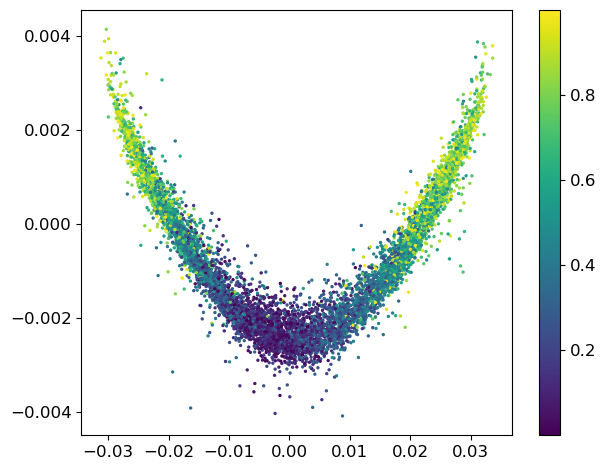

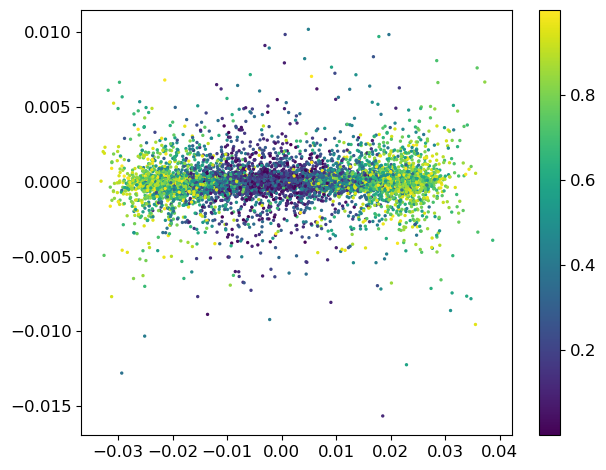

In [15]:
scprep.plot.scatter2d(true_cell_data_phate, time, filename=f'figures/noiseless_time_{dataset}.png', dpi=200, cmap='viridis')
scprep.plot.scatter2d(cell_data_phate, time, filename=f'figures/noisy_time_{dataset}.png', dpi=200, cmap='viridis')

## GSPA branch embeddings

In [26]:
embedding = np.load(f'results/{method}/0_results_{dataset}.npz')['signal_embedding']
localization_score = np.load(f'results/{method}/0_results_{dataset}.npz')['localization_score']

In [27]:
gene_phate_op = phate.PHATE(random_state=1234)
gene_data_phate = gene_phate_op.fit_transform(embedding)

Calculating PHATE...
  Running PHATE on 8823 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.07 seconds.
    Calculating KNN search...
    Calculated KNN search in 8.35 seconds.
    Calculating affinities...
    Calculated affinities in 5.30 seconds.
  Calculated graph and diffusion operator in 13.76 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.09 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.19 seconds.
  Calculated landmark operator in 5.10 seconds.
  Calculating optimal t...
    Automatically selected t = 11
  Calculated optimal t in 1.58 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.49 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.87 seconds.
Calculated PHATE in 24.81 seconds.


In [28]:
gene_clusters = np.array(leidenalg.find_partition(gene_phate_op.graph.to_igraph(), 
                                              leidenalg.ModularityVertexPartition,
                                              seed=0).membership)
gene_clusters = scprep.utils.sort_clusters_by_values(gene_clusters, gene_data_phate[:, 0])

In [29]:
if dataset=='2_branches':
    conv = {4:0, 0:1, 1:2, 2:3, 3:4, 5:5}
    gene_clusters = [conv[x] for x in gene_clusters] # for visualization

In [30]:
if dataset=='3_branches':
    conv = {0:0, 1:1, 4:2, 3:3, 2:4, 5:5}
    gene_clusters = [conv[x] for x in gene_clusters] # for visualization

In [31]:
cmap = sns.color_palette('deep', n_colors=np.array(gene_clusters).max() +1)

<Axes: >

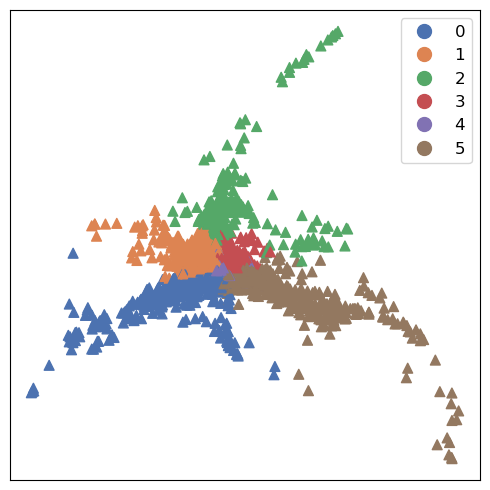

In [32]:
scprep.plot.scatter2d(gene_data_phate, marker='^', c=gene_clusters, cmap=cmap,
                      discrete=True, s=50, ticks=None, figsize=(5,5), filename=f'figures/GSPA_QR_gene_clusters_{dataset}.png', dpi=200)

In [37]:
adata = scanpy.AnnData(true_counts)

/tmp/ipykernel_2652619/111823185.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = scanpy.AnnData(true_counts)


In [38]:
for c in np.unique(gene_clusters):
    scanpy.tl.score_genes(adata, gene_list=adata.var_names[gene_clusters == c],
                          random_state=0, score_name=f'GM_{c}_score',
                          n_bins=int(adata.n_vars * 0.25))

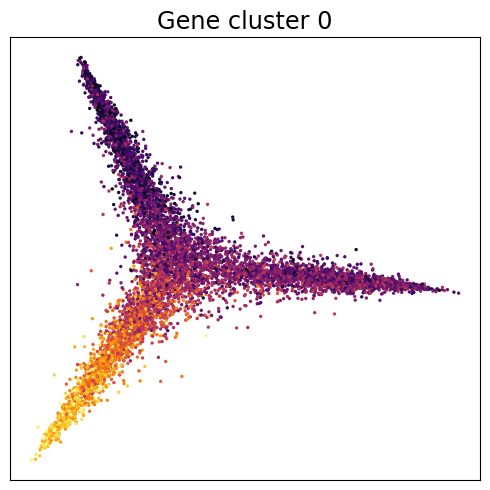

<Figure size 640x480 with 0 Axes>

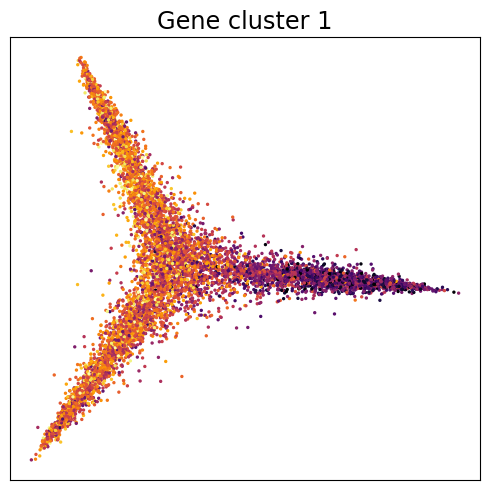

<Figure size 640x480 with 0 Axes>

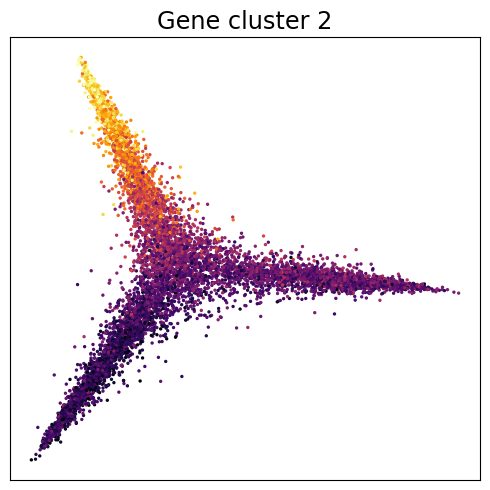

<Figure size 640x480 with 0 Axes>

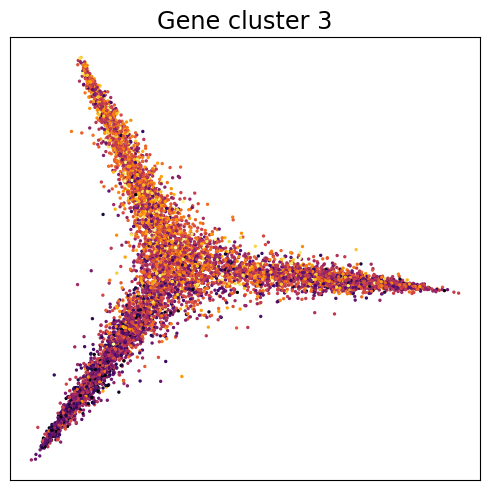

<Figure size 640x480 with 0 Axes>

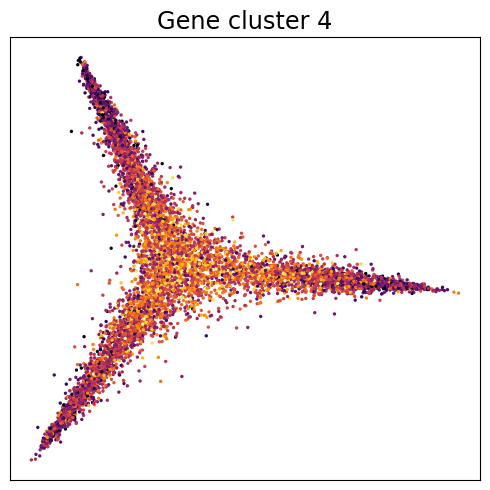

<Figure size 640x480 with 0 Axes>

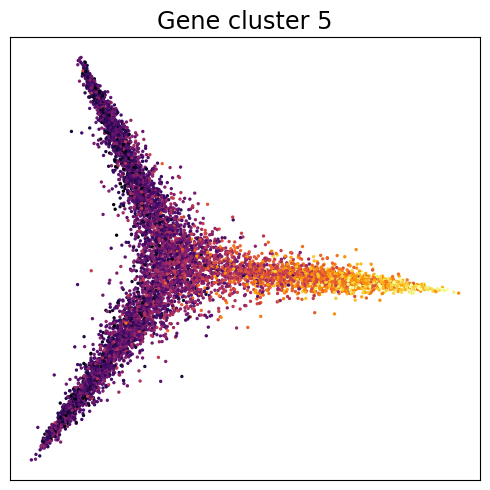

<Figure size 640x480 with 0 Axes>

In [39]:
for c in np.unique(gene_clusters):
    scprep.plot.scatter2d(true_cell_data_phate,
                      c=adata.obs[f'GM_{c}_score'], colorbar=False, ticks=None, figsize=(5,5),
                          vmin=np.percentile(adata.obs[f'GM_{c}_score'], 1),
                          vmax=np.percentile(adata.obs[f'GM_{c}_score'], 99),
                      title=f'Gene cluster {c}', filename=f'figures/gene_cluster_{c}_{dataset}.png', dpi=200)
    
    plt.show(); plt.clf()